In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
datos = pd.read_csv('/Users/cecy/Documents/MCD/IDS/Proyecto_1/incidentes-viales-c5.csv')

In [3]:
datos.shape

(1383138, 18)

In [4]:
datos.head()

,folio,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,fecha_cierre,año_cierre,mes_cierre,hora_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,geopoint,mes
0,GA/160123/05714,23/01/2016,22:35:04,Sábado,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,00:21:08,VENUSTIANO CARRANZA,accidente-choque sin lesionados,19.422113,-99.084643,EMERGENCIA,BOTÓN DE AUXILIO,VENUSTIANO CARRANZA,"19.422113,-99.084643",1
1,AO/160123/05826,23/01/2016,22:50:49,Sábado,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,04:40:37,CUAJIMALPA,accidente-choque con lesionados,19.358320,-99.297641,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,CUAJIMALPA,"19.35832,-99.297641",1
2,C4/160124/02187,24/01/2016,09:40:11,Domingo,(N) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,11:13:03,TLALPAN,accidente-choque sin lesionados,19.217070,-99.219070,EMERGENCIA,LLAMADA DEL 066,TLALPAN,"19.21707,-99.21907008",1
3,C4/160124/05723,24/01/2016,22:40:57,Domingo,(N) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,22:55:51,MAGDALENA CONTRERAS,accidente-choque sin lesionados,19.320580,-99.241010,EMERGENCIA,LLAMADA DEL 066,MAGDALENA CONTRERAS,"19.32057999,-99.24100992",1
4,C4/160124/01334,24/01/2016,04:25:15,Domingo,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,05:03:59,MIGUEL HIDALGO,accidente-choque sin lesionados,19.452900,-99.215870,EMERGENCIA,LLAMADA DEL 066,MIGUEL HIDALGO,"19.45289997,-99.21587004",1


In [5]:
datos.dtypes

folio                 object
fecha_creacion        object
hora_creacion         object
dia_semana            object
codigo_cierre         object
fecha_cierre          object
año_cierre             int64
mes_cierre            object
hora_cierre           object
delegacion_inicio     object
incidente_c4          object
latitud              float64
longitud             float64
clas_con_f_alarma     object
tipo_entrada          object
delegacion_cierre     object
geopoint              object
mes                    int64
dtype: object

In [6]:
datos.nunique()

folio                1383138
fecha_creacion          2637
hora_creacion         105887
dia_semana                 7
codigo_cierre              5
fecha_cierre            2621
año_cierre                 7
mes_cierre                12
hora_cierre           106827
delegacion_inicio         16
incidente_c4              26
latitud                82501
longitud               78984
clas_con_f_alarma          4
tipo_entrada               9
delegacion_cierre         16
geopoint              134288
mes                       12
dtype: int64

In [7]:
datos['año_cierre'] = datos.año_cierre.astype(str)
datos['mes'] = datos.mes.astype(str)

In [8]:
datos.dtypes

folio                 object
fecha_creacion        object
hora_creacion         object
dia_semana            object
codigo_cierre         object
fecha_cierre          object
año_cierre            object
mes_cierre            object
hora_cierre           object
delegacion_inicio     object
incidente_c4          object
latitud              float64
longitud             float64
clas_con_f_alarma     object
tipo_entrada          object
delegacion_cierre     object
geopoint              object
mes                   object
dtype: object

In [9]:
# variables numéricas
number_variables = datos.select_dtypes(include = 'number').columns.values
(len(number_variables), number_variables)

(2, array(['latitud', 'longitud'], dtype=object))

In [10]:
# fechas 
dates_variables = datos.select_dtypes(include = 'datetime').columns.values
(len(dates_variables), dates_variables)

(0, array([], dtype=object))

In [11]:
# variables categóricas
category_variables = datos.select_dtypes(include = 'category').columns.values
(len(category_variables), category_variables)

(0, array([], dtype=object))

In [12]:
# strings 
string_variables = datos.select_dtypes(include = 'object').columns.values
(len(string_variables), string_variables)

(16,
 array(['folio', 'fecha_creacion', 'hora_creacion', 'dia_semana',
        'codigo_cierre', 'fecha_cierre', 'año_cierre', 'mes_cierre',
        'hora_cierre', 'delegacion_inicio', 'incidente_c4',
        'clas_con_f_alarma', 'tipo_entrada', 'delegacion_cierre',
        'geopoint', 'mes'], dtype=object))

In [13]:
# verify if we check for all the types
if (sum([len(number_variables), len(category_variables), 
      len(dates_variables), len(string_variables)]) == datos.shape[1]): 
    print('ok')
else:
    print('columns missing')

ok


In [14]:
def get_repeated_values(df, col, top):
    top_5 = df.groupby([col])[col]\
                    .count()\
                    .sort_values(ascending = False)\
                    .head(3)
    indexes_top_5 = top_5.index
    
    if ((top == 1) and (len(indexes_top_5) > 0)):
        return indexes_top_5[0]
    elif ((top == 2) and (len(indexes_top_5) > 1)):
        return indexes_top_5[1]
    elif ((top == 3) and (len(indexes_top_5) > 2)):
        return indexes_top_5[2]
    else: 
        return 'undefined'

In [15]:
# con talacha
def category_profiling(df, col):
    """
    Profiling for categoric columns. 
    
    :param: column to analyze
    :return: dictionary
    """
    profiling = {}

    profiling.update({'mode': df[col].mode().values,
                     'num_categories': df[col].nunique(),
                     'categories': df[col].unique(),
                     'uniques': df[col].nunique(),
                     'missings': df[col].isna().sum()/df[col].size*100,
                     'top1_repeated': get_repeated_values(df, col, 1),
                     'top2_repeated': get_repeated_values(df, col, 2),
                     'top3_repeated': get_repeated_values(df, col, 3)})
    
    return profiling

In [16]:
category_profiling_output = {elem: category_profiling(datos, elem)\
                             for elem in string_variables}

In [17]:
category_profiling_output
df_category_profiling = pd.DataFrame(category_profiling_output).reset_index()
df_category_profiling.rename(columns = {'index': 'metric'}, inplace = True)
df_category_profiling

,metric,folio,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,fecha_cierre,año_cierre,mes_cierre,hora_cierre,delegacion_inicio,incidente_c4,clas_con_f_alarma,tipo_entrada,delegacion_cierre,geopoint,mes
0,mode,"[AO/140101/01144, AO/140101/02099, AO/140102/0...",[14/02/2020],[20:44:00],[Viernes],[(A) La unidad de atención a emergencias fue d...,[14/02/2020],[2018],[Octubre],[21:59:00],[IZTAPALAPA],[accidente-choque sin lesionados],[EMERGENCIA],[LLAMADA DEL 911],[IZTAPALAPA],"[19.37168001,-99.08024004]",[10]
1,num_categories,1383138,2637,105887,7,5,2621,7,12,106827,16,26,4,9,16,134288,12
2,categories,"[GA/160123/05714, AO/160123/05826, C4/160124/0...","[23/01/2016, 24/01/2016, 25/01/2016, 26/01/201...","[22:35:04, 22:50:49, 09:40:11, 22:40:57, 04:25...","[Sábado, Domingo, Lunes, Martes, Miércoles, Ju...",[(A) La unidad de atención a emergencias fue d...,"[24/01/2016, 25/01/2016, 26/01/2016, 27/01/201...","[2016, 2017, 2018, 2019, 2015, 2014, 2020]","[Enero, Febrero, Marzo, Septiembre, Octubre, M...","[00:21:08, 04:40:37, 11:13:03, 22:55:51, 05:03...","[VENUSTIANO CARRANZA, CUAJIMALPA, TLALPAN, MAG...","[accidente-choque sin lesionados, accidente-ch...","[EMERGENCIA, URGENCIAS MEDICAS, FALSA ALARMA, ...","[BOTÓN DE AUXILIO, LLAMADA DEL 066, RADIO, CÁM...","[VENUSTIANO CARRANZA, CUAJIMALPA, TLALPAN, MAG...","[19.422113,-99.084643, 19.35832,-99.297641, 19...","[1, 2, 3, 9, 10, 5, 6, 4, 8, 12, 7, 11]"
3,uniques,1383138,2637,105887,7,5,2621,7,12,106827,16,26,4,9,16,134288,12
4,missings,0,0,0,0,0,0,0,0,0,0.0114233,0,0,0,0.0101219,0.0322455,0
5,top1_repeated,IZ/201031/08550,14/02/2020,20:44:00,Viernes,(A) La unidad de atención a emergencias fue de...,14/02/2020,2018,Octubre,21:59:00,IZTAPALAPA,accidente-choque sin lesionados,EMERGENCIA,LLAMADA DEL 911,IZTAPALAPA,"19.37168001,-99.08024004",10
6,top2_repeated,C5/160812/06089,26/10/2018,19:16:00,Sábado,(D) El incidente reportado se registró en dos ...,08/12/2017,2019,Agosto,21:52:00,GUSTAVO A. MADERO,accidente-choque con lesionados,URGENCIAS MEDICAS,LLAMADA DEL 066,GUSTAVO A. MADERO,"19.30431996,-99.08714016",8
7,top3_repeated,C5/160812/05979,30/11/2019,18:38:00,Jueves,(N) La unidad de atención a emergencias fue de...,02/12/2017,2017,Septiembre,21:58:00,CUAUHTEMOC,lesionado-atropellado,FALSA ALARMA,BOTÓN DE AUXILIO,CUAUHTEMOC,"19.347021,-99.180646",9


In [18]:
def profiling_var_categoricas(data):
    for column in data.columns:
        if data.dtypes[column] == 'O' and column != 'Geo Point' and column != 'Geo Shape':
            print('\033[1m' + '\033[94m' + column, ":" + '\033[0m')
            print("No. de categorías: {0}".format(len(data[column].unique())))
            print("Categorías: {0}".format(data[column].unique()))
            
            datos_sin_nan = [x for x in datos[column] if pd.notnull(x)]
            print("Moda: {0}".format(datos[column].value_counts().index[0]))
            print("No. de observaciones faltantes: {0}".format(len(data[column]) - len(datos_sin_nan)))
            print("Top 3:\n{0} con {1} observaciones".format(datos[column].value_counts().index[0:3], datos[column].value_counts().values[0:3]))
            print(50*"-")
             
profiling_var_categoricas(datos)

folio :
No. de categorías: 1383138
Categorías: ['GA/160123/05714' 'AO/160123/05826' 'C4/160124/02187' ...
 'C5/201022/02030' 'C5/201022/02039' 'C5/201022/03364']
Moda: C5/171103/04647
No. de observaciones faltantes: 0
Top 3:
Index(['C5/171103/04647', 'C5/160601/06458', 'C5/191018/02082'], dtype='object') con [1 1 1] observaciones
--------------------------------------------------
fecha_creacion :
No. de categorías: 2637
Categorías: ['23/01/2016' '24/01/2016' '25/01/2016' ... '27/10/2020' '28/10/2020'
 '29/10/2020']
Moda: 14/02/2020
No. de observaciones faltantes: 0
Top 3:
Index(['14/02/2020', '26/10/2018', '30/11/2019'], dtype='object') con [1163 1028 1011] observaciones
--------------------------------------------------
hora_creacion :
No. de categorías: 105887
Categorías: ['22:35:04' '22:50:49' '09:40:11' ... '0.986863426' '0.996238426'
 '04:33:05']
Moda: 20:44:00
No. de observaciones faltantes: 0
Top 3:
Index(['20:44:00', '19:16:00', '18:38:00'], dtype='object') con [80 75 74] obser

## Generando etiqueta

In [19]:
def generate_label(data):
    data['label'] = data['codigo_cierre'].str.split(' ', n = 1, expand = False)
    data['label'] = data['label'].apply(lambda x: x[0][1])
    data['label'] = data['label'].apply(lambda x: 1 if x == 'F' or x == 'N' else 0)

In [20]:
generate_label(datos)

In [21]:
datos.columns

Index(['folio', 'fecha_creacion', 'hora_creacion', 'dia_semana',
       'codigo_cierre', 'fecha_cierre', 'año_cierre', 'mes_cierre',
       'hora_cierre', 'delegacion_inicio', 'incidente_c4', 'latitud',
       'longitud', 'clas_con_f_alarma', 'tipo_entrada', 'delegacion_cierre',
       'geopoint', 'mes', 'label'],
      dtype='object')

In [22]:
df = datos.copy()

(A) La unidad de atención a emergencias fue despachada, llegó al lugar de los hechos y confirmó la emergencia reportada

(D) El incidente reportado se registró en dos o más ocasiones procediendo a mantener un único reporte (afirmativo, informativo, negativo o falso) como el identificador para el incidente

(N) La unidad de atención a emergencias fue despachada, llegó al lugar de los hechos, pero en el sitio del evento nadie solicitó el apoyo de la unidad

(F) El operador/a o despachador/a identifican, antes de dar respuesta a la emergencia, que ésta es falsa. O al ser despachada una unidad de atención a emergencias en el lugar de los hechos se percatan que el incidente no corresponde al reportado inicialmente

(I) El incidente reportado es afirmativo y se añade información adicional al evento

In [23]:
df['codigo_cierre'] = np.where(df['codigo_cierre'] == '(A) La unidad de atención a emergencias fue despachada, llegó al lugar de los hechos y confirmó la emergencia reportada', '(A)', df['codigo_cierre'])
df['codigo_cierre'] = np.where(df['codigo_cierre'] == '(D) El incidente reportado se registró en dos o más ocasiones procediendo a mantener un único reporte (afirmativo, informativo, negativo o falso) como el identificador para el incidente', '(D)', df['codigo_cierre'])
df['codigo_cierre'] = np.where(df['codigo_cierre'] == '(N) La unidad de atención a emergencias fue despachada, llegó al lugar de los hechos, pero en el sitio del evento nadie solicitó el apoyo de la unidad', '(N)', df['codigo_cierre'])
df['codigo_cierre'] = np.where(df['codigo_cierre'] == '(F) El operador/a o despachador/a identifican, antes de dar respuesta a la emergencia, que ésta es falsa. O al ser despachada una unidad de atención a emergencias en el lugar de los hechos se percatan que el incidente no corresponde al reportado inicialmente', '(F)', df['codigo_cierre'])
df['codigo_cierre'] = np.where(df['codigo_cierre'] == '(I) El incidente reportado es afirmativo y se añade información adicional al evento', '(I)', df['codigo_cierre'])

In [24]:
df.head()

,folio,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,fecha_cierre,año_cierre,mes_cierre,hora_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,geopoint,mes,label
0,GA/160123/05714,23/01/2016,22:35:04,Sábado,(A),24/01/2016,2016,Enero,00:21:08,VENUSTIANO CARRANZA,accidente-choque sin lesionados,19.422113,-99.084643,EMERGENCIA,BOTÓN DE AUXILIO,VENUSTIANO CARRANZA,"19.422113,-99.084643",1,0
1,AO/160123/05826,23/01/2016,22:50:49,Sábado,(A),24/01/2016,2016,Enero,04:40:37,CUAJIMALPA,accidente-choque con lesionados,19.358320,-99.297641,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,CUAJIMALPA,"19.35832,-99.297641",1,0
2,C4/160124/02187,24/01/2016,09:40:11,Domingo,(N),24/01/2016,2016,Enero,11:13:03,TLALPAN,accidente-choque sin lesionados,19.217070,-99.219070,EMERGENCIA,LLAMADA DEL 066,TLALPAN,"19.21707,-99.21907008",1,1
3,C4/160124/05723,24/01/2016,22:40:57,Domingo,(N),24/01/2016,2016,Enero,22:55:51,MAGDALENA CONTRERAS,accidente-choque sin lesionados,19.320580,-99.241010,EMERGENCIA,LLAMADA DEL 066,MAGDALENA CONTRERAS,"19.32057999,-99.24100992",1,1
4,C4/160124/01334,24/01/2016,04:25:15,Domingo,(A),24/01/2016,2016,Enero,05:03:59,MIGUEL HIDALGO,accidente-choque sin lesionados,19.452900,-99.215870,EMERGENCIA,LLAMADA DEL 066,MIGUEL HIDALGO,"19.45289997,-99.21587004",1,0


In [25]:
def number_formatter(number, pos = None):
    """Convert a number into a human readable format."""
    magnitude = 0
    while abs(number) >= 1000:
        magnitude += 1
        number /= 1000
    return '%.1f%s' % (number, ['', 'K', 'M', 'B', 'T', 'Q'][magnitude])

## Definiendo opciones y variables a usar en gráficas

In [34]:
cod_order = ["(A)", "(D)", "(N)", "(F)", "(I)"]
cod_colors = ["seagreen", "lightsteelblue", "tomato", "darkred", "dodgerblue"]
cod_Palette = sns.set_palette(sns.color_palette(cod_colors))

In [53]:
label_order = [0, 1]
label_colors = ["seagreen", "indianred"]
label_Palette = sns.set_palette(sns.color_palette(label_colors))

In [28]:
dia_orden = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]
mes_orden = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]
anio_orden = ["2014", "2015", "2016", "2017", "2018", "2019", "2020"]
del_orden = ['IZTAPALAPA', 'CUAUHTEMOC', 'GUSTAVO A. MADERO', 'MIGUEL HIDALGO',
       'BENITO JUAREZ', 'COYOACAN', 'VENUSTIANO CARRANZA', 'ALVARO OBREGON',
       'TLALPAN', 'AZCAPOTZALCO', 'IZTACALCO', 'XOCHIMILCO', 'TLAHUAC',
       'CUAJIMALPA', 'MAGDALENA CONTRERAS', 'MILPA ALTA']

# CÓDIGOS

## Frecuencia códigos de cierre

In [29]:
codigos_cierre = pd.DataFrame(df['codigo_cierre'].value_counts())
codigos_cierre = codigos_cierre.rename(columns = {'codigo_cierre':'counts'})
codigos_cierre

,counts
(A),600108
(D),495631
(N),271677
(F),10626
(I),5096


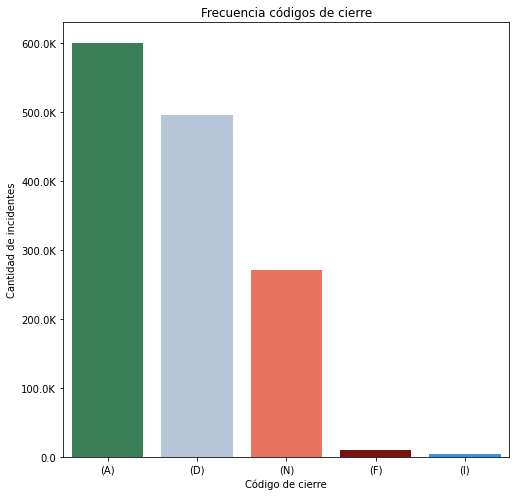

In [35]:
plt.figure(figsize = (8,8))
ax = sns.barplot(x = codigos_cierre.index, y = 'counts', data = codigos_cierre, palette = cod_Palette)
ax.set(title = 'Frecuencia códigos de cierre', xlabel = 'Código de cierre', ylabel = 'Cantidad de incidentes')
#plt.xticks(rotation = 0) 
ax.yaxis.set_major_formatter(FuncFormatter(number_formatter))
plt.show()

# ETIQUETAS

In [36]:
label_del = df.groupby(['label','delegacion_inicio'], as_index = False).size()
label_dia = df.groupby(['label','dia_semana'], as_index = False).size()
label_mes = df.groupby(['label','mes_cierre'], as_index = False).size()
label_anio = df.groupby(['label','año_cierre'], as_index = False).size()
label_hora = df.groupby(['label','hora_creacion'], as_index = False).size()

In [37]:
label_total = pd.DataFrame(df['label'].value_counts())
label_total = label_total.rename(columns = {'label':'counts'})

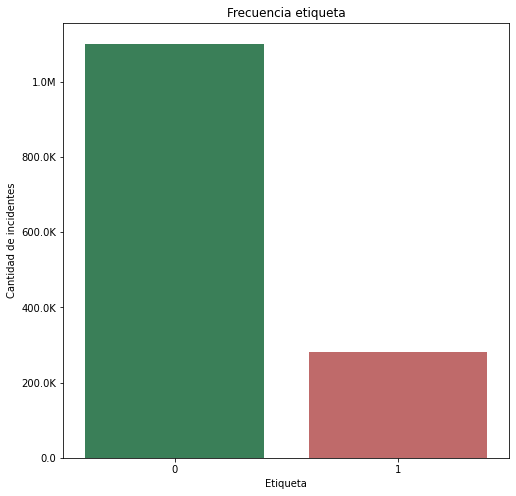

In [54]:
plt.figure(figsize = (8,8))
ax = sns.barplot(x = label_total.index, 
                 y = 'counts', 
                 data = label_total, 
                 palette = label_Palette)
ax.set(title = 'Frecuencia etiqueta', xlabel = 'Etiqueta', ylabel = 'Cantidad de incidentes')
ax.yaxis.set_major_formatter(FuncFormatter(number_formatter))
plt.show()

## Etiqueta por Delegación

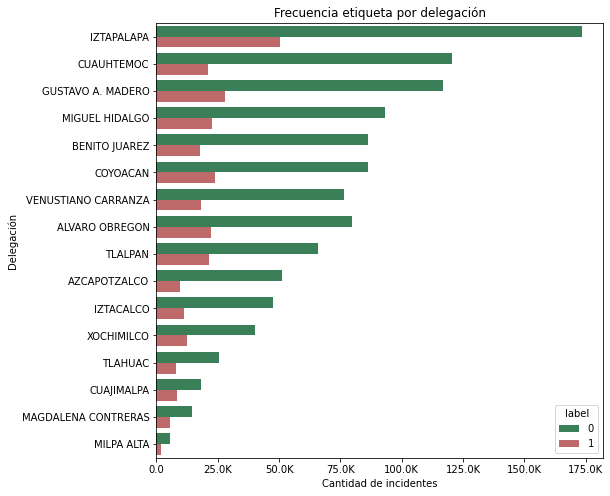

In [55]:
plt.figure(figsize = (8,8)) 
ax = sns.barplot(y = "delegacion_inicio", 
                 x = "size", 
                 data = label_del, 
                 hue = "label", 
                 order = del_orden,
                 palette = label_colors)
ax.set(title = 'Frecuencia etiqueta por delegación', xlabel = 'Cantidad de incidentes', ylabel = 'Delegación')
ax.xaxis.set_major_formatter(FuncFormatter(number_formatter))
plt.show()

## Etiqueta por día

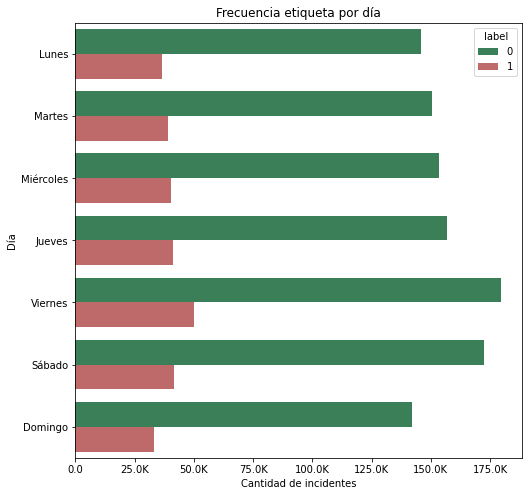

In [56]:
plt.figure(figsize = (8,8)) 
ax = sns.barplot(y = "dia_semana", 
                 x = "size", 
                 data = label_dia, 
                 hue = "label", 
                 order = dia_orden,
                 palette = label_colors)
ax.set(title = 'Frecuencia etiqueta por día', xlabel = 'Cantidad de incidentes', ylabel = 'Día')
ax.xaxis.set_major_formatter(FuncFormatter(number_formatter))
plt.show()

## Etiqueta por mes

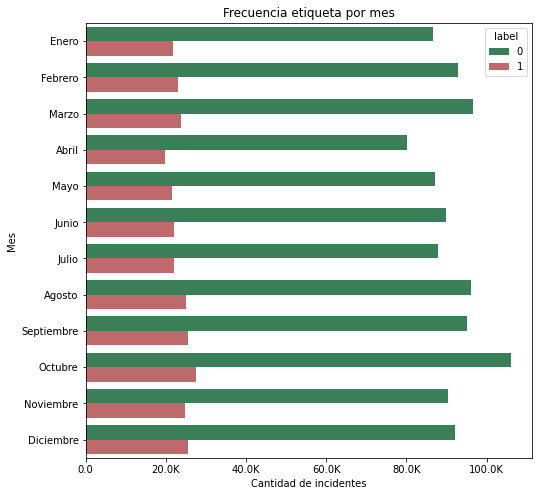

In [57]:
plt.figure(figsize = (8,8)) 
ax = sns.barplot(y = "mes_cierre", 
                 x = "size", 
                 data = label_mes, 
                 hue = "label", 
                 order = mes_orden,
                 palette = label_colors)
ax.set(title = 'Frecuencia etiqueta por mes', xlabel = 'Cantidad de incidentes', ylabel = 'Mes')
ax.xaxis.set_major_formatter(FuncFormatter(number_formatter))
plt.show()

## Etiqueta por año

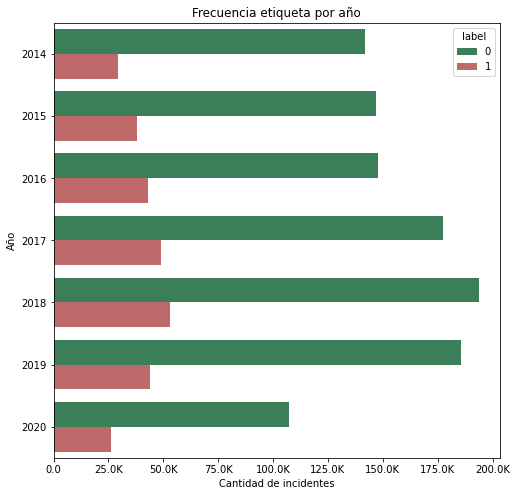

In [58]:
plt.figure(figsize = (8,8)) 
ax = sns.barplot(y = "año_cierre", 
                 x = "size", 
                 data = label_anio, 
                 hue = "label", 
                 order = anio_orden,
                 palette = label_colors)
ax.xaxis.set_major_formatter(FuncFormatter(number_formatter))
ax.set(title = 'Frecuencia etiqueta por año', xlabel = 'Cantidad de incidentes', ylabel = 'Año')
plt.show()

## *clas_con_f_alarma*

In [45]:
clas_total = pd.DataFrame(df['clas_con_f_alarma'].value_counts())
clas_total = clas_total.rename(columns = {'clas_con_f_alarma':'counts'})
clas_label = df.groupby(['label','clas_con_f_alarma'], as_index = False).size()

In [138]:
clas_total_orden = ['EMERGENCIA', 'URGENCIAS MEDICAS', 'FALSA ALARMA', 'DELITO']

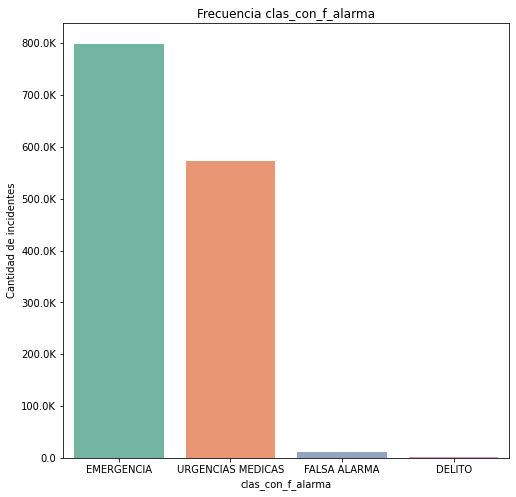

In [122]:
plt.figure(figsize = (8,8))
ax = sns.barplot(x = clas_total.index, 
                 y = 'counts', 
                 data = clas_total,
                 palette = "Set2")
ax.set(title = 'Frecuencia clas_con_f_alarma', xlabel = 'clas_con_f_alarma', ylabel = 'Cantidad de incidentes')
ax.yaxis.set_major_formatter(FuncFormatter(number_formatter))
plt.show()

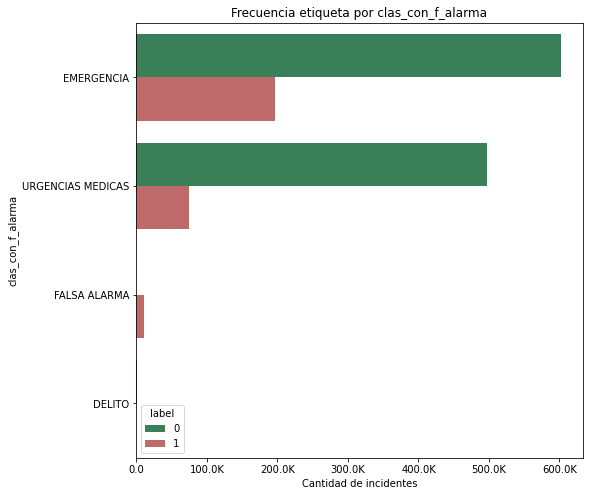

In [139]:
plt.figure(figsize = (8,8)) 
ax = sns.barplot(y = "clas_con_f_alarma", 
                 x = "size", 
                 data = clas_label, 
                 hue = "label", 
                 order = clas_total_orden,
                 palette = label_colors)
ax.xaxis.set_major_formatter(FuncFormatter(number_formatter))
ax.set(title = 'Frecuencia etiqueta por clas_con_f_alarma', xlabel = 'Cantidad de incidentes', ylabel = 'clas_con_f_alarma')
plt.show()

In [48]:
df["misma_del"] = np.where(df["delegacion_inicio"] == df["delegacion_cierre"], True, False)

In [49]:
comparacion_del = pd.DataFrame(df['misma_del'].value_counts())
comparacion_del = comparacion_del.rename(columns = {'misma_del':'counts'}, index = {True:'Sí', False:'No'})
comparacion_del

,counts
Sí,1339176
No,43962


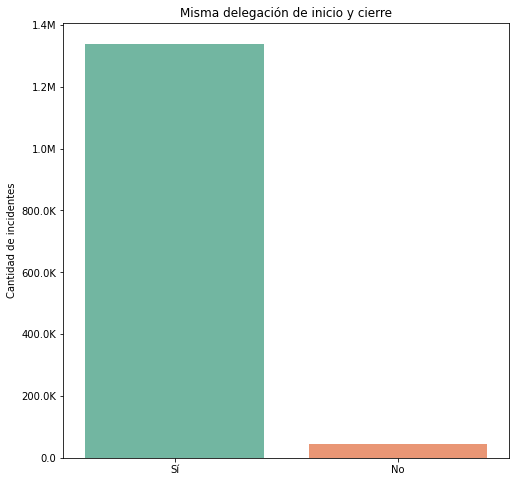

In [125]:
plt.figure(figsize = (8,8))
ax = sns.barplot(x = comparacion_del.index, 
                 y = 'counts', 
                 data = comparacion_del,
                 palette = "Set2")
ax.set(title = 'Misma delegación de inicio y cierre', ylabel = 'Cantidad de incidentes')
ax.yaxis.set_major_formatter(FuncFormatter(number_formatter))
plt.show()

In [95]:
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [52]:
mapa_cdmx = gpd.read_file('/Users/cecy/Documents/MCD/IDS/Proyecto_1/df_municipio.shp')

In [336]:
#crs = {'init': 'epsg:4326'}  #Inicializando el sistema de coordenadas

In [85]:
geometry = [Point(xy) for xy in zip(df["longitud"], df["latitud"])]   #Creando las variables tipo Point a usar
geo_df = gpd.GeoDataFrame(df, geometry = geometry)  #Creando GeoPandas DF

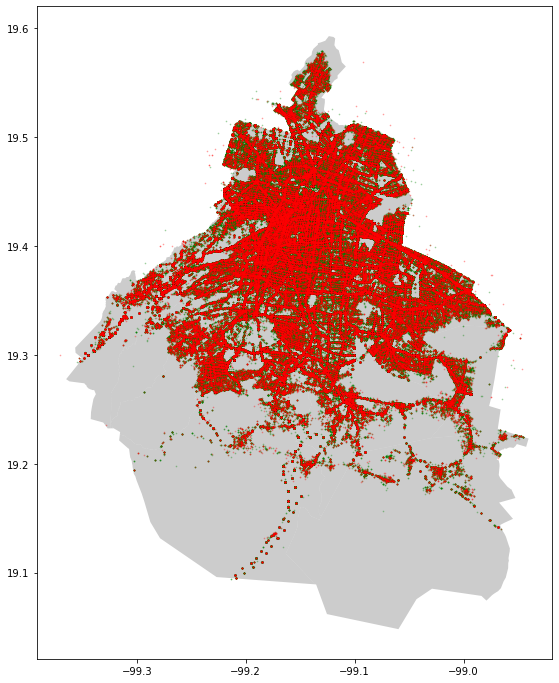

In [92]:
fig,ax = plt.subplots(figsize = (12,12))
mapa_cdmx.plot(ax = ax, alpha = 0.4, color = "grey")
geo_df[geo_df['label']==0].plot(ax=ax, markersize=0.5, color="green", alpha=0.3, label="0")
geo_df[geo_df['label']==1].plot(ax=ax, markersize=0.5, color="red", alpha=0.3, label="1")
plt.show()

#geo_df[geo_df['label']==0].plot(ax = ax, markersize = 1, color = "green", marker = "o", alpha = 0.3, label = "0") #, label = "0"
#geo_df[geo_df['label']==1].plot(ax = ax, markersize = 1, color = "red", marker = "o", alpha = 0.3, label = "1") #, label = "1"
#plt.legend(prop = {'size':12}, markerscale = 8)
#plt.title("Etiqueta en el mapa", fontweight = "bold", fontsize = "15")
#plt.xlabel("Longitud (°)")
#plt.ylabel("Latitud (°)")

Text(0.5, 1.0, '1')

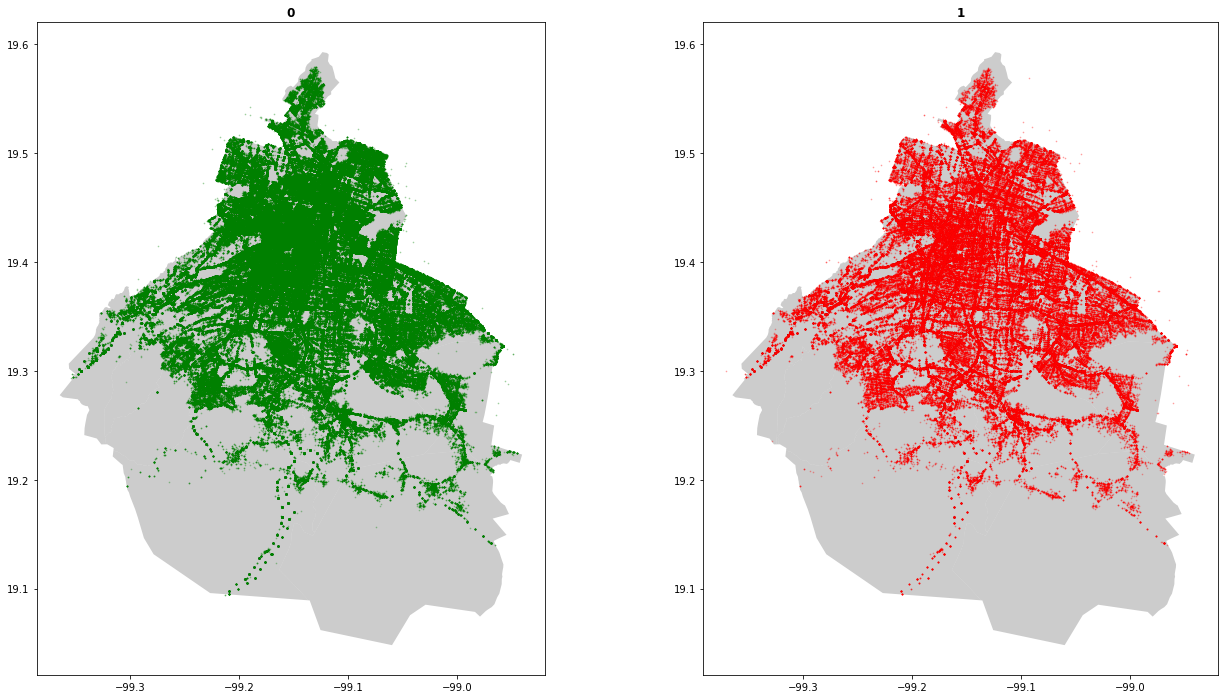

In [124]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,12))

mapa_cdmx.plot(ax=axes[0], alpha = 0.4, color = "grey")
geo_df[geo_df['label']==0].plot(ax=axes[0], markersize=0.5, color="green", alpha=0.3)
axes[0].set_title('0', fontweight = "bold")

mapa_cdmx.plot(ax=axes[1], alpha = 0.4, color = "grey")
geo_df[geo_df['label']==1].plot(ax=axes[1], markersize=0.5, color="red", alpha=0.3)
axes[1].set_title('1', fontweight = "bold")


## Tipo de entrada

In [128]:
tipo_entrada_total = pd.DataFrame(df['tipo_entrada'].value_counts())
tipo_entrada_total = tipo_entrada_total.rename(columns = {'tipo_entrada':'counts'})
tipo_entrada_label = df.groupby(['label','tipo_entrada'], as_index = False).size()

In [135]:
tipo_entrada_orden = ['LLAMADA DEL 911', 'LLAMADA DEL 066', 'BOTÓN DE AUXILIO', 'RADIO',
       'LLAMADA APP911', 'ZELLO', 'REDES', 'CÁMARA', 'APLICATIVOS']

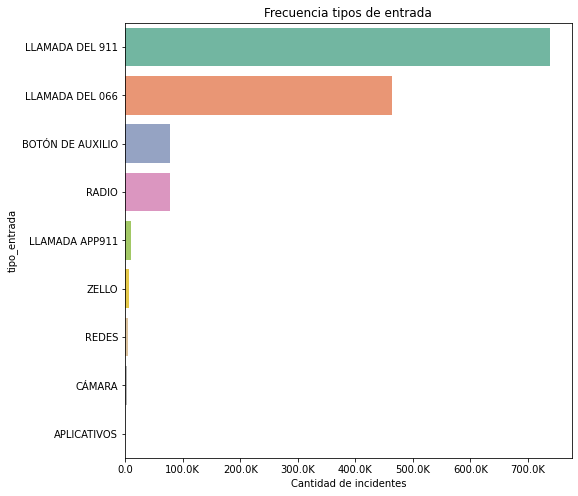

In [130]:
plt.figure(figsize = (8,8))
ax = sns.barplot(y = tipo_entrada_total.index, 
                 x = 'counts', 
                 data = tipo_entrada_total,
                 palette = "Set2")
ax.set(title = 'Frecuencia tipos de entrada', ylabel = 'tipo_entrada', xlabel = 'Cantidad de incidentes')
ax.xaxis.set_major_formatter(FuncFormatter(number_formatter))
plt.show()

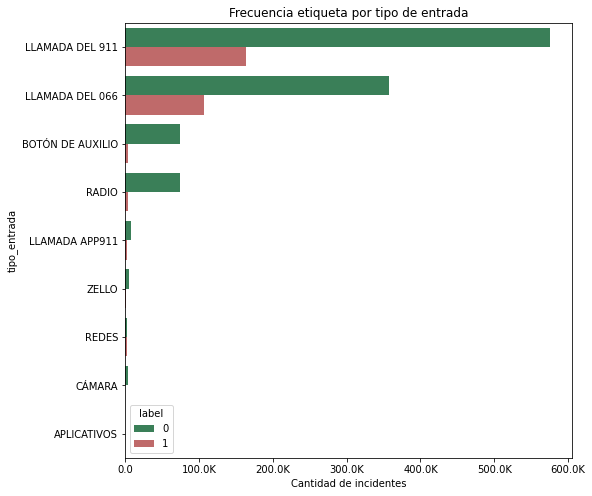

In [136]:
plt.figure(figsize = (8,8)) 
ax = sns.barplot(y = "tipo_entrada", 
                 x = "size", 
                 data = tipo_entrada_label, 
                 hue = "label", 
                 order = tipo_entrada_orden,
                 palette = label_colors)
ax.xaxis.set_major_formatter(FuncFormatter(number_formatter))
ax.set(title = 'Frecuencia etiqueta por tipo de entrada', xlabel = 'Cantidad de incidentes', ylabel = 'tipo_entrada')
plt.show()